<a href="https://colab.research.google.com/github/srikar8/EIP3_phase2/blob/master/srikar_gradcam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train/=255
#x_test/=255
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


Using TensorFlow backend.


In [2]:
!pip install image-classifiers

In [3]:
from classification_models import Classifiers
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers.advanced_activations import Softmax
classifier, preprocess_input = Classifiers.get('resnet18')
model = classifier((32, 32, 3), weights='imagenet', include_top=False)
x=model.output    
x=Flatten()(x)
x = Dense(256, activation='softmax')(x)
#x = Dropout(0.5)(x)
predictions=Dense(10, activation='softmax')(x)
model = Model(inputs=model.input, outputs=predictions)
model.summary()

W0701 19:18:37.968040 139979387676544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0701 19:18:37.992040 139979387676544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0701 19:18:37.992915 139979387676544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0701 19:18:37.997313 139979387676544 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0701 19:18:37.998588 139979

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

In [0]:
predict = model.predict(x_test)

In [0]:
import numpy as np
predicted_labels = [np.argmax(x, axis=-1) for x in predict]
labels = [np.argmax(x, axis=-1) for x in y_test]
indices = [i for i, x in enumerate(predicted_labels) if predicted_labels[i]!=labels[i]]

In [0]:
def get_imgs_by_idices(generator, ids):
  gen_len = len(generator)
  imgs = []
  for idx in ids:
    img = generator[idx]
    imgs.append(img)
  imgs = np.array(imgs)
  return imgs

In [0]:
import random
fault_images_random = random.sample([i for i in range(len(indices))], 50)
miss_classified_images = get_imgs_by_idices(x_test, fault_images_random)

In [0]:
from keras import backend as k
import cv2


def gradCam(model, img, layer_name, heatmap_opacity=0.4):
  x = np.expand_dims(img, axis=0)
  preds = model.predict(x)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer(layer_name)
  grads = k.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = k.mean(grads, axis=(0, 1, 2))
  iterate = k.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([x])
  for i in range(128):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  img = np.uint8(255 * img)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 1-heatmap_opacity, heatmap, heatmap_opacity, 0)
  
  return superimposed_img

In [11]:
heatmap_imgs = []

for w_img in miss_classified_images:
  heatmap_img = gradCam(model, w_img, layer_name="stage4_unit2_conv2")
  heatmap_imgs.append(heatmap_img)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6

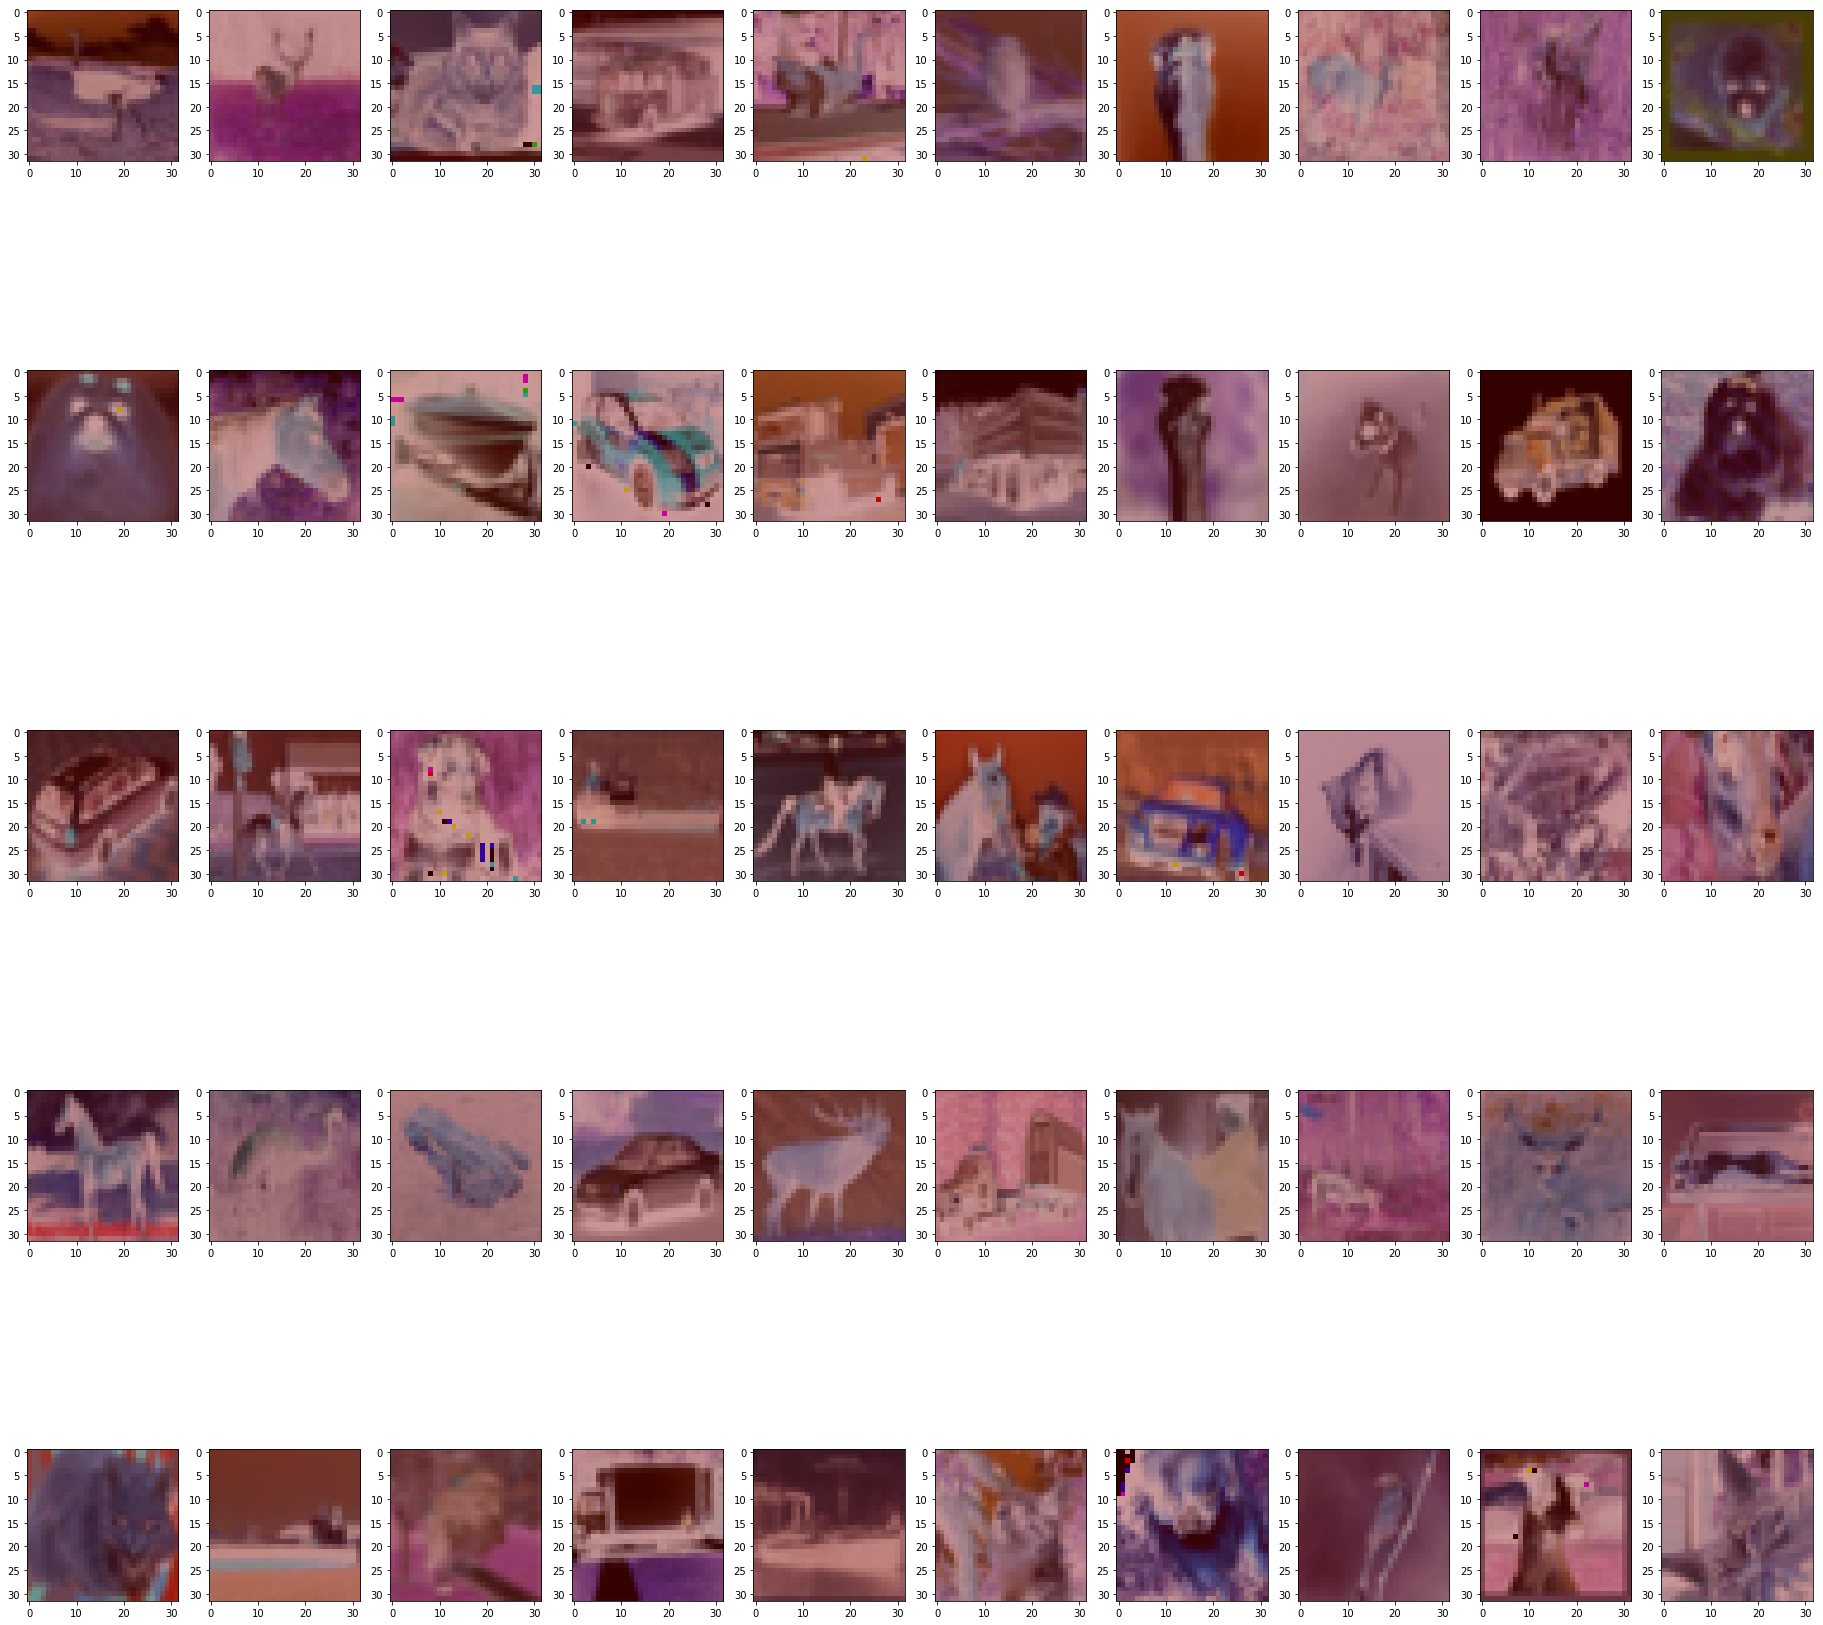

In [13]:
import matplotlib.pyplot as plt
plot_x = 5
plot_y = 10
fig, ax = plt.subplots(plot_x, plot_y, figsize = (32,32))

for i in range(plot_y):
  for j in range(plot_x):
    idx = i*plot_x + j
    ax[j, i].imshow(heatmap_imgs[idx])